In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import hops
from src.util import noise_generator

In [2]:
def extract_auxillary_state(psi, n):
    contr = psi.Bs[-1][:, 0, n[-1]] # vL
    for i in range(N_terms-1, 0, -1):
        contr = np.tensordot(psi.Bs[i][:, :, n[-1-i]], contr, ([1], [0])) # vL [vR], [vL] -> vL
    result = np.tensordot(psi.Bs[0][0, :, :], contr, ([0], [0])) # [vR] i, [vL] -> i
    return result * psi.norm

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30
# BCF
N_terms = 1
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [4]:
N_steps = 1000
N_trunc = 40
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True
}

In [5]:
options['rescale_aux'] = True
my_homps_rescaled = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_rescaled = my_homps_rescaled.compute_realizations(1, collect_debug_info=True)

In [6]:
options['rescale_aux'] = False
my_homps_default = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_default = my_homps_default.compute_realizations(1, collect_debug_info=True)

In [7]:
sigma_zs_rescaled = compute_exp_val_linear(psis_rescaled, sigma_z)
sigma_zs_default = compute_exp_val_linear(psis_default, sigma_z)

In [8]:
np.save("data/high_T_sigma_zs_rescaled", sigma_zs_rescaled)
np.save("data/high_T_sigma_zs_default", sigma_zs_default)

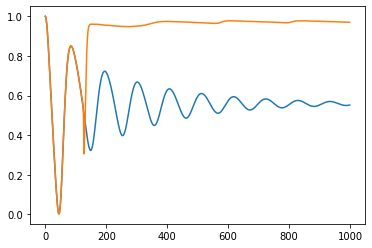

In [9]:
plt.plot(sigma_zs_rescaled)
plt.plot(sigma_zs_default)
plt.show()

In [10]:
# Extract auxillary states from default HOPS
auxillary_states_default = np.empty((N_trunc, N_steps, 2), dtype=complex)
auxillary_magnitudes_default = np.empty((N_trunc, N_steps), dtype=complex)
for n in range(N_trunc):
    for i in range(N_steps):
        auxillary_states_default[n, i, :] = extract_auxillary_state(my_homps_default.debug_info['full_state'][0][i], [n])
        auxillary_magnitudes_default[n, i] = np.linalg.norm(auxillary_states_default[n, i, :])

In [11]:
# Extract auxillary states from rescaled HOPS
auxillary_states_rescaled = np.empty((N_trunc, N_steps, 2), dtype=complex)
auxillary_magnitudes_rescaled = np.empty((N_trunc, N_steps), dtype=complex)
for n in range(N_trunc):
    for i in range(N_steps):
        auxillary_states_rescaled[n, i, :] = extract_auxillary_state(my_homps_rescaled.debug_info['full_state'][0][i], [n])
        auxillary_magnitudes_rescaled[n, i] = np.linalg.norm(auxillary_states_rescaled[n, i, :])

In [13]:
for n in range(N_trunc):
    np.save(f"data/high_T_magnitudes_rescaled_{n}", auxillary_magnitudes_rescaled[n])
    np.save(f"data/high_T_magnitudes_default_{n}", auxillary_magnitudes_default[n])